# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import clear_output
from fastprogress import master_bar, progress_bar
import pathlib
import PIL
from tqdm import tqdm
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

# plt.xkcd();  # commic plots plt.rcdefaults() to disable

PyTorch Version:  0.4.1


# Load data

In [52]:
dataset_dir = pathlib.Path("D:/Datasets/TFM/ISIC-2017")
num_workers = 0  # 4 for linux
batch_size  = 64
num_classes = 4
scale       = 360
input_shape = 540 #224
mean        = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
std         = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

class skinDataset(Dataset):

	def __init__(self, subset):
		self.data_dir   = dataset_dir / ("data_"+subset)
		self.csv_file   = dataset_dir / ("ground_truth_"+subset+".csv")
		self.labels     = pd.read_csv(self.csv_file)
		self.labels_map = {0 : "melanoma", 1 : "seborrheic", 2 : "healthy"};
		self.subset     = subset
		self.transform  = True
		self.transforms = {
			"train": transforms.Compose([
				#transforms.Resize(scale),
				transforms.RandomResizedCrop(input_shape),
				transforms.RandomHorizontalFlip(),
				transforms.RandomVerticalFlip(),
				transforms.RandomRotation(degrees=90),
				transforms.ToTensor(),
				transforms.Normalize(mean, std)]),
			"val": transforms.Compose([
				#transforms.Resize(scale),
				transforms.CenterCrop(input_shape),
				transforms.ToTensor(),
				transforms.Normalize(mean, std)]),
			"test": transforms.Compose([
				transforms.ToTensor(),
				transforms.Normalize(mean, std)])}

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		img_name = self.data_dir / (self.labels.iloc[idx, 0] + ".jpg")
		image    = PIL.Image.open(img_name)
		if self.transform: image = self.transforms[self.subset](image)

		label    = self.labels.iloc[idx, 1:3].values.tolist()
		if   label[0]==1.0: label = 0 #"melanoma"
		elif label[1]==1.0: label = 1 #"seborrheic_keratosis"
		else:               label = 2 #"healthy"

		return image, label


dataset    = {subset: skinDataset(subset) for subset in ["train", "valid", "test"]}
dataloader = {subset: DataLoader(dataset[subset], batch_size=batch_size, shuffle=True, num_workers=num_workers) for subset in ["train", "valid", "test"]}
{print("There are", len(dataset[subset]), "images in the "+subset+" dataset.") for subset in ["train", "valid", "test"]};

There are 2000 images in the train dataset.
There are 150 images in the valid dataset.
There are 600 images in the test dataset.


# Min sizes of the images

In [36]:
for phase in ["train", "valid", "test"]:
	sizes = {}
	for i in range(len(dataset[phase])):
		img_name = dataset[phase].data_dir / (dataset[phase].labels.iloc[i, 0] + ".jpg")
		image    = PIL.Image.open(img_name)
		size     = image.size

		if size in sizes: sizes[size] += 1
		else:             sizes[size] = 1

	min_w = 10000
	min_h = 10000
	for s in sizes:
		if s[0] < min_w: min_w = s[0]
		if s[1] < min_h: min_h = s[1]
	
	print(phase)
	print("\tminimun width  =", min_w)
	print("\tminimun height =", min_h)

train
	minimun width  = 576
	minimun height = 540
valid
	minimun width  = 1024
	minimun height = 768
test
	minimun width  = 639
	minimun height = 602


# Check if data is balanced

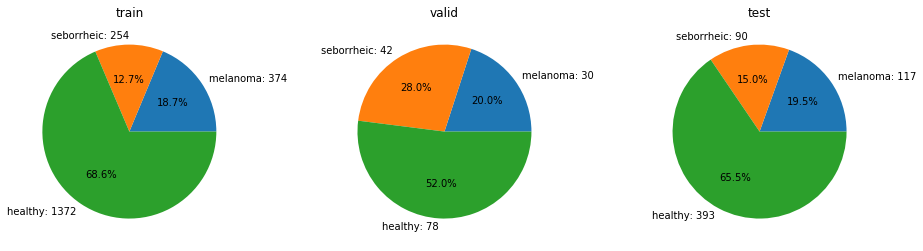

In [79]:
labels = "melanoma", "seborrheic", "healthy"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

for p, phase in enumerate(["train", "valid", "test"]):
	count = [0, 0, 0]
	for idx in range(len(dataset[phase])):
		label    = dataset[phase].labels.iloc[idx, 1:3].values.tolist()
		if   label[0]==1.0: class_number = 0 #"melanoma"
		elif label[1]==1.0: class_number = 1 #"seborrheic_keratosis"
		else:               class_number = 2 #"healthy"            
		count[class_number] += 1

	labels2 = [a+": "+str(b) for a, b in zip(labels, count)]
	axs[p].set_title(phase)
	axs[p].pie(count, labels=labels2, autopct='%1.1f%%');

# Show data

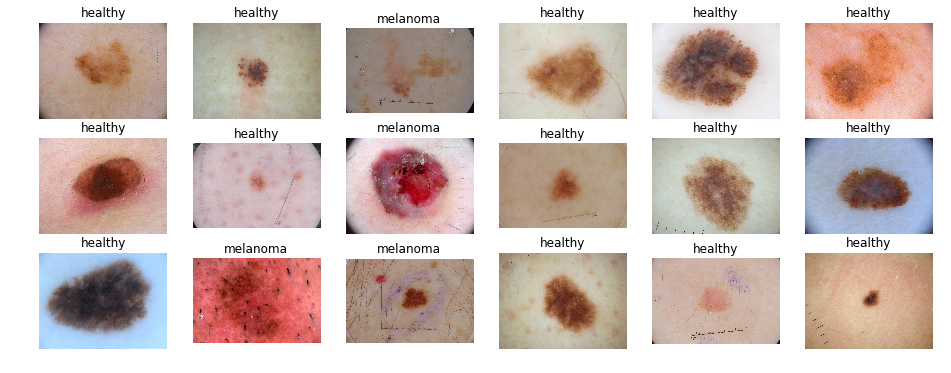

In [54]:
def show_dataset(subset):
	dataset[subset].transform = False
	fig = plt.figure(figsize=(16,6));
	columns = 6;
	rows = 3;

	for i in range(1, columns*rows +1):
		idx = np.random.randint(len(dataset[subset]));
		img, lbl = dataset[subset][idx]

		fig.add_subplot(rows, columns, i)

		plt.title(dataset[subset].labels_map[lbl])
		plt.axis('off')
		plt.imshow(img)
	plt.show()
	dataset[subset].transform = True
    
show_dataset("train")